In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('cl4.csv')

In [60]:
df = df_raw[(df_raw['REG_YYMM'] == 202001) | (df_raw['REG_YYMM'] == 202002) | (df_raw['REG_YYMM'] == 202003)]
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month
4983,202001,서울,건강보조식품 소매업,20s,1,1,208,16160890,253,1,2020,1
4984,202001,서울,건강보조식품 소매업,20s,2,1,371,25956734,432,1,2020,1
4985,202001,서울,건강보조식품 소매업,20s,2,2,10,2425550,11,1,2020,1
4986,202001,서울,건강보조식품 소매업,30s,1,1,43,3931710,46,1,2020,1
4987,202001,서울,건강보조식품 소매업,30s,1,2,1007,106500031,1186,1,2020,1


# Data Preprocessing

In [61]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [62]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [63]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [64]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [65]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
4983,서울,건강보조식품 소매업,20s,1,1,208,16160890,253,1,2020,1,Winter
4984,서울,건강보조식품 소매업,20s,2,1,371,25956734,432,1,2020,1,Winter
4985,서울,건강보조식품 소매업,20s,2,2,10,2425550,11,1,2020,1,Winter
4986,서울,건강보조식품 소매업,30s,1,1,43,3931710,46,1,2020,1,Winter
4987,서울,건강보조식품 소매업,30s,1,2,1007,106500031,1186,1,2020,1,Winter


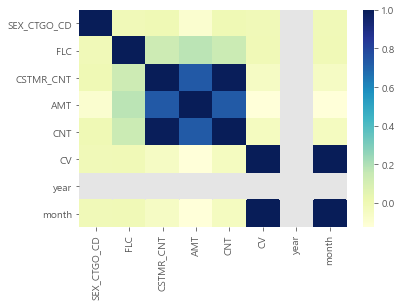

In [66]:
sns.heatmap(df.corr(),cmap='YlGnBu',fmt='.1g')

# Label Encoding

In [67]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192 entries, 4983 to 6174
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CARD_SIDO_NM  1192 non-null   int32
 1   STD_CLSS_NM   1192 non-null   int32
 2   AGE           1192 non-null   int32
 3   SEX_CTGO_CD   1192 non-null   int64
 4   FLC           1192 non-null   int64
 5   CSTMR_CNT     1192 non-null   int64
 6   AMT           1192 non-null   int64
 7   CNT           1192 non-null   int64
 8   CV            1192 non-null   int64
 9   year          1192 non-null   int64
 10  month         1192 non-null   int64
 11  Season        1192 non-null   int32
dtypes: int32(4), int64(8)
memory usage: 102.4 KB


In [69]:
df.STD_CLSS_NM.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [70]:
df['month'].unique()

array([1, 2, 3], dtype=int64)

# Preprocessing

In [71]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [72]:
X = df.drop(['AMT'], axis=1)
y = np.log1p(df['AMT'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [74]:
X_train

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,CNT,CV,year,month,Season
4983,0,0,1,1,1,208,253,1,2020,1,1
4984,0,0,1,2,1,371,432,1,2020,1,1
4985,0,0,1,2,2,10,11,1,2020,1,1
4986,0,0,2,1,1,43,46,1,2020,1,1
4987,0,0,2,1,2,1007,1186,1,2020,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5812,0,0,4,2,4,1876,2298,3,2020,3,0
5813,0,0,5,1,5,1565,1937,3,2020,3,0
5814,0,0,5,2,5,2230,2650,3,2020,3,0
5815,0,0,6,1,5,929,1115,3,2020,3,0


# Stacking

In [75]:
estimators = [('rf', RandomForestRegressor(n_estimators=300)),
              ('gb', GradientBoostingRegressor(n_estimators=300)),
              ('knn', KNeighborsRegressor())]

In [76]:
# build model
Stacking_Model = StackingRegressor(estimators=estimators)

labels = y_train
features = X_train

# Fit the RF model with features and labels.
st_reg=Stacking_Model.fit(features, labels)

In [77]:
print("Score on training set : {:.3f}".format(st_reg.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(st_reg.score(X_test,y_test)))

Score on training set : 0.984
Score on test set : 0.935


In [78]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    st_reg.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    st_reg.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
SR_predict = X_train_predict.append(X_test_predict)

In [79]:
np.sqrt(mean_squared_error(y_test, st_reg.predict(X_test)))

0.6488243646390841

In [80]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [81]:
df2 = df[(df['year']==2020) & (df['month']==2)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [82]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [83]:
# 예측
pred = st_reg.predict(temp)
pred = np.expm1(pred)

In [84]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [85]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = ((v['4월'] - v['3월']) / v['3월']) * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,건강보조식품 소매업,1.562084e+10,1178972099,1224.954495
1,골프장 운영업,1.284964e+10,364764050,3422.725290
2,과실 및 채소 소매업,7.482444e+09,8005379734,-6.532308
3,관광 민예품 및 선물용품 소매업,4.064710e+09,53586140,7485.374763
4,그외 기타 스포츠시설 운영업,4.843891e+09,15888500,30386.771652
5,기타 수상오락 서비스업,1.780772e+09,3946900,45018.256556
6,기타 주점업,1.150088e+10,1463780040,685.697485
7,내항 여객 운송업,7.213889e+09,1103089720,553.971193
8,마사지업,1.378302e+10,144174546,9459.951638
9,면세점,1.165663e+10,35502010,32733.711179


# Light Gradient Boosting Machine

In [86]:
import lightgbm as lgb

In [87]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [88]:
params = {
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1        }

In [89]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.678738
Early stopping, best iteration is:
[74]	valid_0's rmse: 0.668707


# Template

In [90]:
X.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT',
       'CNT', 'CV', 'year', 'month', 'Season'],
      dtype='object')

In [91]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [92]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,year,month,Season
0,0,0,1,1,1,2020,4,1
1,0,0,1,1,1,2020,4,0
2,0,0,1,1,1,2020,7,1
3,0,0,1,1,1,2020,7,0
4,0,0,1,1,2,2020,4,1
...,...,...,...,...,...,...,...,...
5315,0,18,0,2,4,2020,7,0
5316,0,18,0,2,5,2020,4,1
5317,0,18,0,2,5,2020,4,0
5318,0,18,0,2,5,2020,7,1


In [93]:
df2 = df[(df['year']==2020) & (df['month']==2)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [94]:
df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [95]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [96]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [97]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [98]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [99]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감량'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감량
0,건강보조식품 소매업,5.132587e+09,1178972099,335.344224
1,골프장 운영업,4.007638e+09,364764050,998.693358
2,과실 및 채소 소매업,2.673434e+09,8005379734,-66.604538
3,관광 민예품 및 선물용품 소매업,2.042552e+09,53586140,3711.716981
4,그외 기타 스포츠시설 운영업,1.387075e+09,15888500,8630.053762
5,기타 수상오락 서비스업,5.667516e+08,3946900,14259.411690
6,기타 주점업,3.764453e+09,1463780040,157.173408
7,내항 여객 운송업,3.916635e+09,1103089720,255.060463
8,마사지업,5.104259e+09,144174546,3440.333287
9,면세점,5.560438e+09,35502010,15562.318855
